# Preparing dataset

In [1]:
import pickle
with open("final_project/enron_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
source_df = pd.DataFrame.from_dict(data_dict, orient = 'index')


In [3]:
source_df.drop('TOTAL',inplace=True)

## Fields

In [4]:
payments_features = ['salary', 'bonus', 'long_term_incentive',
                     'deferred_income', 'deferral_payments', 'loan_advances',
                     'other', 'expenses', 'director_fees', 'total_payments']
stock_features = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred',
                  'total_stock_value']

email_features = ['to_messages', 'from_poi_to_this_person',
                  'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
target_field = 'poi'


## Payments

In [5]:

payments = source_df[payments_features]
payments = payments.replace('NaN', 0)

## Check correctness

In [6]:
errors = payments[payments[payments_features[:-1]].sum(axis='columns') != payments['total_payments']]
errors.head()

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments
BELFER ROBERT,0,0,0,0,-102500,0,0,0,3285,102500
BHATNAGAR SANJAY,0,0,0,0,0,0,137864,0,137864,15456290


# Make a shift on payments

In [7]:
import numpy as np
shifted_values = payments.loc['BELFER ROBERT', payments_features[1:]].values

expected_payments = shifted_values.sum()
shifted_values = np.append(shifted_values, expected_payments)
payments.loc['BELFER ROBERT', payments_features] = shifted_values

shifted_values = payments.loc['BHATNAGAR SANJAY', payments_features[:-1]].values
payments.loc['BHATNAGAR SANJAY', payments_features] = np.insert(shifted_values, 0, 0)

In [8]:
errors = payments[payments[payments_features[:-1]].sum(axis='columns') != payments['total_payments']]
errors.head()

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments


## Stocks

In [9]:
stocks = source_df[stock_features]

stocks = stocks.replace('NaN', 0)

In [10]:
errors = stocks[stocks[stock_features[:-1]].sum(axis='columns') != stocks['total_stock_value']]
errors.head()

,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
BELFER ROBERT,3285,0,44093,-44093
BHATNAGAR SANJAY,2604490,-2604490,15456290,0


In [11]:

shifted_values = stocks.loc['BELFER ROBERT', stock_features[1:]].values

expected_payments = shifted_values.sum()
shifted_values = np.append(shifted_values, expected_payments)
stocks.loc['BELFER ROBERT', stock_features] = shifted_values

shifted_values = stocks.loc['BHATNAGAR SANJAY', stock_features[:-1]].values
stocks.loc['BHATNAGAR SANJAY', stock_features] = np.insert(shifted_values, 0, shifted_values[-1])

In [12]:
errors = stocks[stocks[stock_features[:-1]].sum(axis='columns') != stocks['total_stock_value']]
errors.head()

,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value


## Emails

In [13]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer()

## Fill the gaps

In [14]:
target = source_df[target_field]
email_data = source_df[email_features]
email_data = pd.concat([email_data, target], axis=1)
email_data_poi = email_data[email_data[target_field]][email_features]
email_data_nonpoi = email_data[email_data[target_field] == False][email_features]

email_data_poi[email_features] = imp.fit_transform(email_data_poi)
email_data_nonpoi[email_features] = imp.fit_transform(email_data_nonpoi)
email_data = email_data_poi.append(email_data_nonpoi)

## Collect them all

In [15]:
df = payments.join(stocks)
df = df.join(email_data)
df = df.astype(float)

## Remove outliers

In [16]:

first_quartile = df.quantile(q=0.25)
third_quartile = df.quantile(q=0.75)
IQR = third_quartile - first_quartile
outliers = df[(df > (third_quartile + 1.5 * IQR)) | (df < (first_quartile - 1.5 * IQR))].count(axis=1)
outliers.sort_values(axis=0, ascending=False, inplace=True)
outliers = outliers.head(10)
outliers

LAY KENNETH L         14
FREVERT MARK A        12
BAXTER JOHN C          8
BELDEN TIMOTHY N       8
LAVORATO JOHN J        8
SKILLING JEFFREY K     8
WHALLEY LAWRENCE G     7
KEAN STEVEN J          7
HAEDICKE MARK E        7
DELAINEY DAVID W       6
dtype: int64

### Filter non-poi outliers

In [17]:
target_for_outliers = target.loc[outliers.index]
outliers = pd.concat([outliers, target_for_outliers], axis=1)
non_poi_outliers = outliers[np.logical_not(outliers.poi)]
df.drop(non_poi_outliers.index, inplace=True)
non_poi_outliers.index

Index(['FREVERT MARK A', 'BAXTER JOHN C', 'LAVORATO JOHN J',
       'WHALLEY LAWRENCE G', 'KEAN STEVEN J', 'HAEDICKE MARK E'],
      dtype='object')

In [18]:
from sklearn.preprocessing import scale
df[df.columns] = scale(df)

In [19]:
target.drop(non_poi_outliers.index, inplace=True)


In [20]:
target = target.map({True: 1, False: 0})

In [21]:
target.value_counts()



0    121
1     18
Name: poi, dtype: int64

# Features


## MultiCollinear

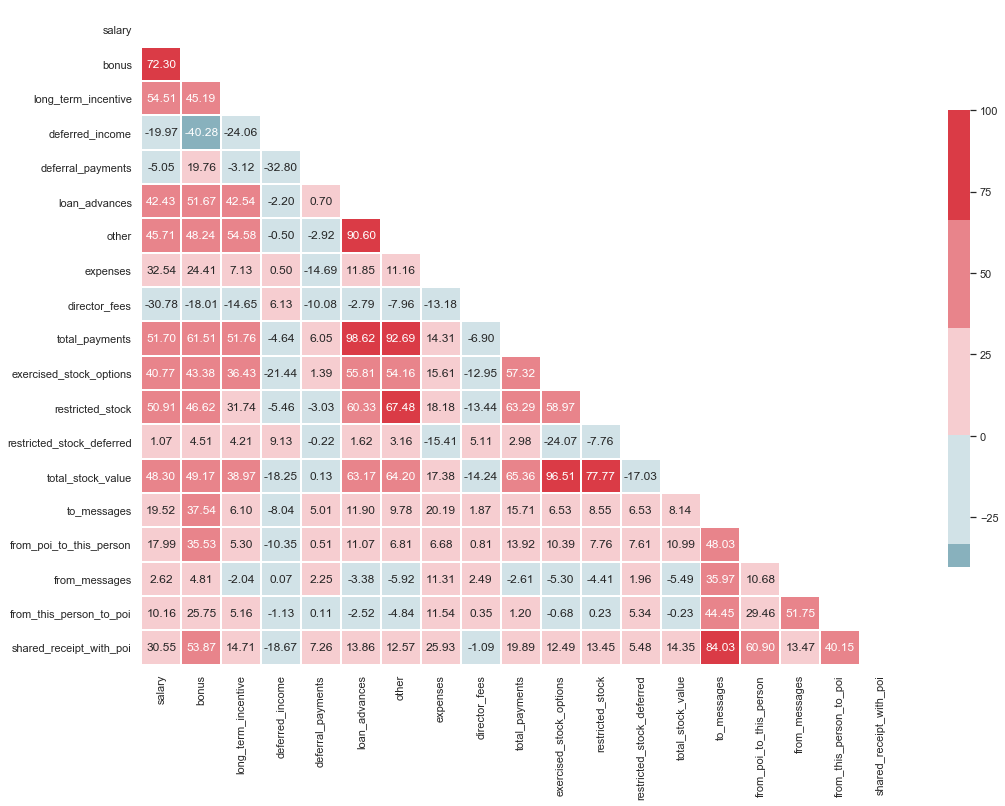

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

corr = df.corr() * 100

# Select upper triangle of correlation matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(17, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            linewidths=1, cbar_kws={"shrink": .7}, annot=True, fmt=".2f")
plt.savefig('books_read.png')


In [23]:
df.drop(columns=['total_payments', 'total_stock_value'], inplace=True)

In [24]:
df['ratio_of_poi_mail'] = df['from_poi_to_this_person']/df['to_messages']
df['ratio_of_mail_to_poi'] = df['from_this_person_to_poi']/df['from_messages']

In [25]:
assert 'poi' not in df.columns

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

The most important columns are bonus,deferred_income,other,exercised_stock_options,shared_receipt_with_poi,ratio_of_poi_mail,ratio_of_mail_to_poi


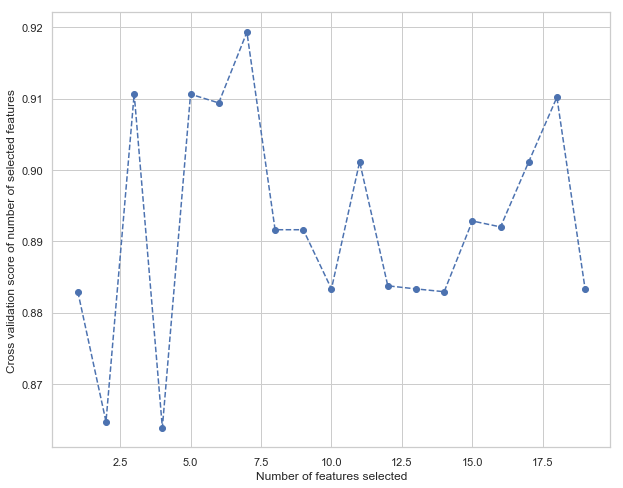

In [27]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=forest, cv=5, scoring='accuracy')
rfecv = rfecv.fit(X_train, y_train)
# f, ax = plt.subplots()
plt.figure(figsize=(10, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, '--o')
indices = rfecv.get_support()
columns = X_train.columns[indices]
print('The most important columns are {}'.format(','.join(columns)))


In [28]:
X_train = X_train[columns]
X_test = X_test[columns]

In [29]:
X_train.describe()

,bonus,deferred_income,other,exercised_stock_options,shared_receipt_with_poi,ratio_of_poi_mail,ratio_of_mail_to_poi
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,-0.019260,-0.002480,0.012729,0.025299,-0.061382,-1.136341,0.513203
std,0.989253,1.074191,1.108285,1.053122,0.984706,11.236064,2.100902
min,-0.551255,-6.216550,-0.243647,-0.415638,-1.304246,-80.239938,-19.547139
25%,-0.551255,0.251847,-0.243647,-0.415638,-0.661146,0.580052,0.214340
50%,-0.362044,0.298324,-0.243052,-0.295605,-0.017404,0.580052,0.650738
75%,0.134635,0.298324,-0.140825,-0.083476,-0.017404,1.019890,1.304679
max,6.071134,0.298324,10.644436,6.557627,5.417851,12.208117,4.648623


In [30]:
y_train.unique()

array([0, 1])

In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


random_state = 42
gnb = GaussianNB()
svc = SVC(random_state=random_state)
knn = KNeighborsClassifier()
log = LogisticRegression(random_state=random_state)
rfc = RandomForestClassifier(random_state=random_state)
mlp = MLPClassifier(random_state=random_state)


In [32]:
classifiers = [gnb, svc, knn, log, rfc, mlp]

In [33]:
for clf in classifiers:
    clf.fit(X_train, y_train)

In [34]:
from sklearn.metrics import accuracy_score
def calculate_accuracy(X, y):
    result = pd.DataFrame(columns=['classifier', 'accuracy'])
    for clf in classifiers:
        predicted = clf.predict(X_test)
        accuracy = round(100.0 * accuracy_score(y_test, predicted), 2)
        classifier = clf.__class__.__name__
        classifier = classifier.replace('Classifier', '')
        result = result.append({'classifier': classifier, 'accuracy': accuracy}, ignore_index=True)
        print('Accuracy is {accuracy}% for {classifier_name}'.format(accuracy=accuracy, classifier_name=classifier))

    result = result.sort_values(['classifier'], ascending=True)
    plt.subplots(figsize=(10, 7))
    sns.barplot(x="classifier", y='accuracy', palette=cmap, data=result)

Accuracy is 92.86% for GaussianNB
Accuracy is 92.86% for SVC
Accuracy is 85.71% for KNeighbors
Accuracy is 89.29% for LogisticRegression
Accuracy is 89.29% for RandomForest
Accuracy is 89.29% for MLP


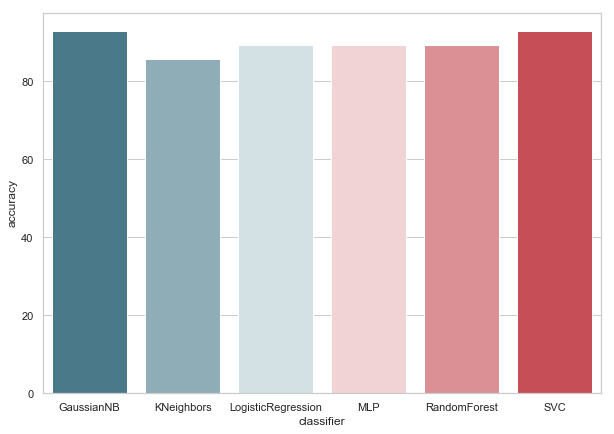

In [35]:
calculate_accuracy(X_train, y_train)

## Confussion matrix

In [36]:
from sklearn.metrics import confusion_matrix

def make_confussion_matrices(X, y):
    matrices = {}
    result = pd.DataFrame(columns=['classifier', 'recall'])
    for clf in classifiers:
        classifier = clf.__class__.__name__
        classifier = classifier.replace('Classifier', '')
        predicted = clf.predict(X_test)
        print(f'{predicted}-{classifier}')
        matrix = confusion_matrix(y_test,predicted,labels=[1,0])
        matrices[classifier] = matrix.T
    return matrices



In [37]:
matrices = make_confussion_matrices(X_train,y_train)

[0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0]-GaussianNB
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]-SVC
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]-KNeighbors
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]-LogisticRegression
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]-RandomForest
[0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]-MLP


In [38]:
import itertools
from collections import Iterable
def draw_confussion_matrices(row,col,matrices,figsize = (16,12)):
    fig, (axes) = plt.subplots(row,col, sharex='col', sharey='row',figsize=figsize )
    if any(isinstance(i, Iterable) for i in axes):
        axes =  list(itertools.chain.from_iterable(axes))
        
    idx = 0
    for name,matrix in matrices.items():
        df_cm = pd.DataFrame(
            matrix, index=['True','False'], columns=['True','False'], 
        )

        ax = axes[idx]
        fig.subplots_adjust(wspace=0.1)
        sns.heatmap(df_cm, annot=True,cmap=cmap,cbar=False ,fmt="d",ax=ax,linewidths=1) 
        ax.set_title(name)
        idx += 1

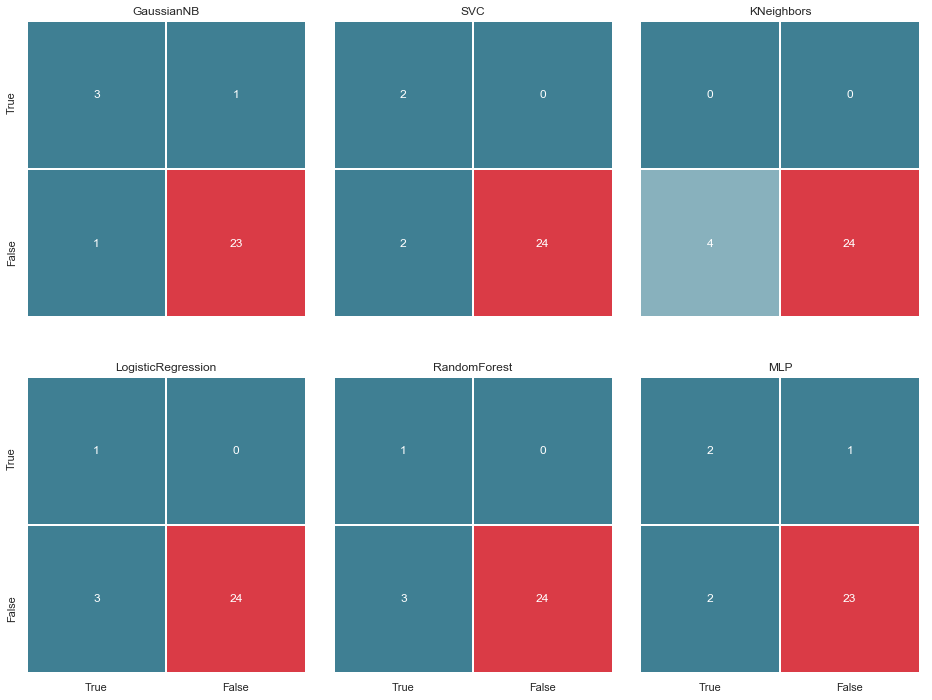

In [39]:
draw_confussion_matrices(2,3,matrices)

# Metrics

In [40]:
from sklearn.metrics import precision_score
def calculate_precision(X, y):
    result = pd.DataFrame(columns=['classifier', 'precision'])
    for clf in classifiers:
        
        predicted = clf.predict(X_test)
        precision = precision_score(y_test, predicted, average='macro')
        classifier = clf.__class__.__name__
        classifier = classifier.replace('Classifier', '')
        result = result.append({'classifier': classifier, 'precision': precision}, ignore_index=True)
        print('Precision is {precision}% for {classifier_name}'.format(precision=precision, classifier_name=classifier))

    result = result.sort_values(['classifier'], ascending=True)
    plt.subplots(figsize=(10, 7))
    sns.barplot(x="classifier", y='precision', palette=cmap, data=result)

Precision is 0.8541666666666667% for GaussianNB
Precision is 0.9615384615384616% for SVC
Precision is 0.42857142857142855% for KNeighbors
Precision is 0.9444444444444444% for LogisticRegression
Precision is 0.9444444444444444% for RandomForest
Precision is 0.7933333333333333% for MLP


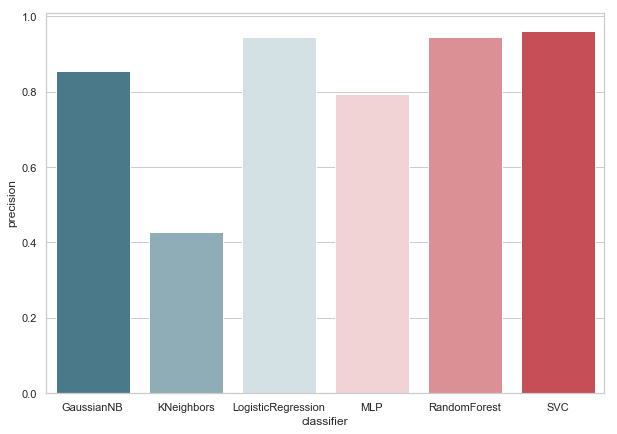

In [41]:
calculate_precision(X_train, y_train)

## Hyperparameters

In [42]:
classifiers.remove(gnb)

In [43]:
parameters = {'SVC':{'kernel':('linear', 'rbf','poly'), 'C':[i for i in range(1,11)],'random_state': (random_state,)}, 
             'KNeighbors':{'algorithm':('ball_tree', 'kd_tree'), 'n_neighbors':[i for i in range(2,20)]},
             'LogisticRegression':{'penalty':('l1', 'l2'), 'C':[i for i in range(1,11)],'random_state': (random_state,)},
             'RandomForest':{'n_estimators':[i for i in range(10,101,10)],'random_state': (random_state,)},
             'MLP':{'activation':('relu','logistic'),'solver':('sgd','lbfgs'),'max_iter':(500,1000), 'hidden_layer_sizes':[(7,),(7,7)],'random_state': (random_state,)}}


In [44]:
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')
for idx,clf in enumerate(classifiers):
    classifier = clf.__class__.__name__
    classifier = classifier.replace('Classifier', '')
    params = parameters.get(classifier)
    if not params:
        continue

    new_clf = clf.__class__()
    gs = GridSearchCV(new_clf, params, cv=5)
    result =gs.fit(X_train, y_train)
    print(f'The best params for {classifier} are {result.best_params_}')
    classifiers[idx] = result.best_estimator_

The best params for SVC are {'C': 1, 'kernel': 'poly', 'random_state': 42}
The best params for KNeighbors are {'algorithm': 'ball_tree', 'n_neighbors': 3}
The best params for LogisticRegression are {'C': 1, 'penalty': 'l1', 'random_state': 42}
The best params for RandomForest are {'n_estimators': 30, 'random_state': 42}
The best params for MLP are {'activation': 'relu', 'hidden_layer_sizes': (7, 7), 'max_iter': 500, 'random_state': 42, 'solver': 'sgd'}


## Conclussion

In [64]:
first_row = {"SVC":matrices['SVC'],"KNeighbors":matrices['KNeighbors']}
second_row = {"LogisticRegression":matrices['LogisticRegression'],"RandomForest":matrices['RandomForest'],"MLP":matrices['MLP']}

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]-SVC
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]-KNeighbors
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]-LogisticRegression
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]-RandomForest
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]-MLP


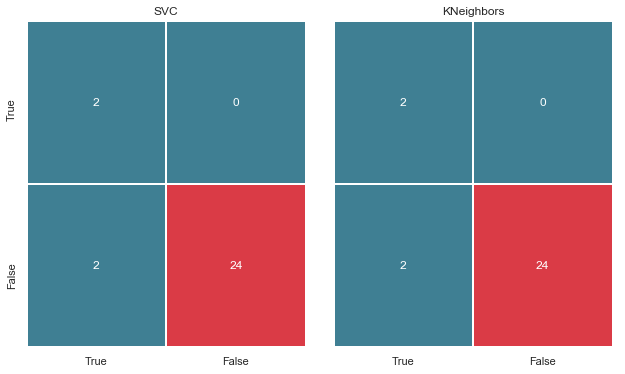

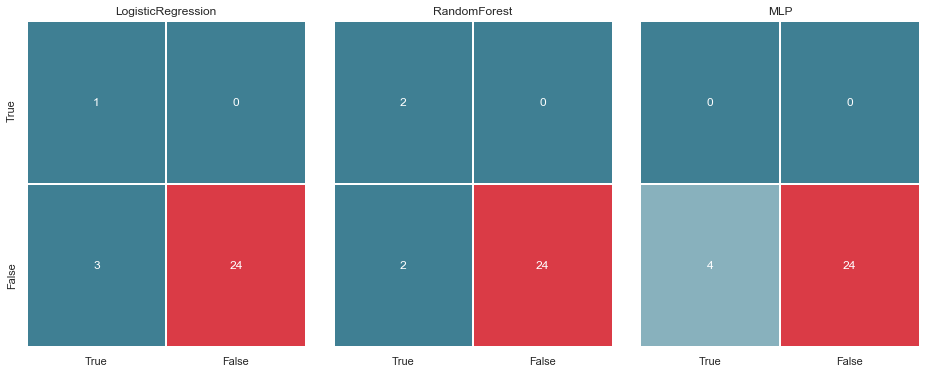

In [65]:
matrices = make_confussion_matrices(X_train,y_train)
draw_confussion_matrices(1,2,first_row,figsize = (10.5,6))
draw_confussion_matrices(1,3,second_row,figsize = (16,6))
